##Predicting Sarcasm using Word2Vec+LSTMs

In [ ]:
#importing libraries
!pip install gensim
import numpy as np
import pandas as pd
import matplotlib as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

#using word2vec for word embeddings
import nltk
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from gensim.models import Word2Vec


nltk.download('punkt_tab')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); np.random.seed(0); random.seed(0)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#loading datasets
train_df = pd.read_csv('train.csv')
print('train set has been loaded!')
train_df.name = 'train'
valid_df = pd.read_csv('valid.csv')
print('valid set has been loaded!')
valid_df.name = 'valid'
test_df = pd.read_csv('test.csv')
print('test set has been loaded!')
test_df.name = 'test'

train_labels = torch.tensor(
    train_df['label'].values,
    dtype=torch.float32
)
valid_labels = torch.tensor(
    valid_df['label'].values,
    dtype=torch.float32
)
test_labels = torch.tensor(
    test_df['label'].values,
    dtype=torch.float32
)


train set has been loaded!
valid set has been loaded!
test set has been loaded!


In [ ]:
#looking at features of train_df, valid_df, and test_df:
def features(df):
  print(f"Dataset: {df.name}")
  print(f"Size: {df.shape}")
  print(f"Columns: {df.columns}")
  print(f"Null Values: {df.isnull().sum()}")
  print(f"Head: {df.head()}\n")
  print(f"Description:\n{df.describe()}\n")

  #longest phrase in dataset
  max_len = 0
  max_len_phrase = ""
  for i in range(len(df)):
    if len(df['text'][i]) > max_len:
      max_len = len(df['text'][i])
      max_len_phrase = df['text'][i]
  print(f"Longest Phrase in Dataset: \n{max_len_phrase}, \nchar length {max_len}")

  #count of sarcasm vs non-sarcasm
  sarcasm_count = df['label'].value_counts()[1]
  non_sarcasm_count = df['label'].value_counts()[0]
  print(f"Sarcasm Count: {sarcasm_count}")
  print(f"Non-Sarcasm Count: {non_sarcasm_count}")
  print("-----------------------------")

features(train_df)
features(valid_df)
features(test_df)

Dataset: train
Size: (21464, 2)
Columns: Index(['text', 'label'], dtype='object')
Null Values: text     0
label    0
dtype: int64
Head:                                                 text  label
0  states slow to shut down weak teacher educatio...      0
1    drone places fresh kill on steps of white house      1
2  report: majority of instances of people gettin...      1
3  sole remaining lung filled with rich, satisfyi...      1
4                       the gop's stockholm syndrome      0

Description:
              label
count  21464.000000
mean       0.475960
std        0.499433
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Longest Phrase in Dataset: 
hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis bal

Based on the information above, there does not seem to be any null values in any of the datasets.

In [ ]:
#extract text from sarcasm labels
train_text = train_df['text']
valid_text = valid_df['text']
test_text = test_df['text']

#tokenizing them
def tokenize(series):
    data = []
    for text in series:
        tokens = [w.lower() for w in word_tokenize(text)]
        data.append(tokens)
    return data


train_tokens = tokenize(train_text)
print(train_tokens)
valid_tokens = tokenize(valid_text)
test_tokens = tokenize(test_text)

[['states', 'slow', 'to', 'shut', 'down', 'weak', 'teacher', 'education', 'programs'], ['drone', 'places', 'fresh', 'kill', 'on', 'steps', 'of', 'white', 'house'], ['report', ':', 'majority', 'of', 'instances', 'of', 'people', 'getting', 'lives', 'back', 'on', 'track', 'occur', 'immediately', 'after', 'visit', 'to', 'buffalo', 'wild', 'wings'], ['sole', 'remaining', 'lung', 'filled', 'with', 'rich', ',', 'satisfying', 'flavor'], ['the', 'gop', "'s", 'stockholm', 'syndrome'], ['trump', "'s", 'game', 'plan'], ['lea', 'michele', 'romances', 'fake', 'gosling', 'in', "'on", 'my', 'way', "'", 'video'], ['report', ':', 'that', 'whole', 'side', 'of', 'family', 'just', 'like', 'that'], ['new', 'extended', 'paternity', 'leave', 'offers', 'dads', 'more', 'time', 'to', 'lose', 'colleagues', "'", 'respect'], ['nation', 'hopeful', 'there', 'will', 'be', 'equally', 'random', 'chance', 'of', 'justice', 'for', 'future', 'victims', 'of', 'police', 'abuse'], ['sean', 'spicer', 'finally', 'calls', 'it', '

In [ ]:
#getting vocab:
def build_vocab(tokens):
  counter = Counter(word for sent in tokens for word in sent)
  vocab = {
    "<PAD>": 0,
    "<UNK>": 1
  }
  for word in counter:
    vocab[word] = len(vocab)

  return vocab

train_vocab = build_vocab(train_tokens)


In [ ]:
#converts tokens into numerical indices for model to interpret from
#also does padding/truncating
def numericalize(tokens, vocab, max_len=30):
  seq = [vocab.get(w, vocab["<UNK>"]) for w in tokens]
  return seq[:max_len] + [vocab["<PAD>"]] * max(0, max_len - len(seq))

train_sequences = torch.tensor([numericalize(s, train_vocab) for s in train_tokens])
valid_sequences = torch.tensor([numericalize(s, train_vocab) for s in valid_tokens])
test_sequences  = torch.tensor([numericalize(s, train_vocab) for s in test_tokens])

#print(train_sequences.max())
#print(len(train_vocab))
#print(train_embeddings.shape)


In [ ]:
#uncomment only if you dont have GloVe already downloaded
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip -q glove.6B.zip

def load_glove_embeddings(glove_path, vocab, embed_dim=50):
    embeddings = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector

    embedding_matrix = np.zeros((len(vocab), embed_dim))

    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = embeddings[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)
glove_embeddings = load_glove_embeddings(
    "glove.6B.50d.txt",
    train_vocab,
    embed_dim=50
)


In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
    #loading w2v weights
    self.embed.weight.data.copy_(embed_matrix)
    self.embed.weight.requires_grad = True
    #using Bidirectional since that is good for retaining context
    self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
    self.fc1 = nn.Linear(hidden_dim * 4, 1)

  def forward(self, x):
    emb = self.embed(x)
    out, (h_n, _) = self.lstm(emb)
    avg_pool = out.mean(dim=1)
    max_pool, _ = out.max(dim=1)
    h = torch.cat([avg_pool, max_pool], dim=1)
    logits = self.fc1(h)
    return logits.squeeze(1)

In [ ]:
class LSTMModelGloVE(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embed.weight.data.copy_(embed_matrix)
        #freeze embedding weights (not needed for training and makes it more stable)
        self.embed.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.4)
        self.drop1 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 4, 1) #concatenate both of the poolings, which are both hidden_dim * 2
        #self.fc = nn.Linear(hidden_dim * 2, 1) #only if we use one pooling and not concatenating them

    def forward(self, x):
      emb = self.embed(x)
      out, (h_n, _) = self.lstm(emb)
      avg_pool = out.mean(dim=1)
      max_pool, _ = out.max(dim=1)
      #h = torch.cat([max_pool, avg_pool], dim=1)
      h = torch.cat([avg_pool, max_pool], dim=1)
      #h = self.drop1(avg_pool)
      #h = self.drop1(max_pool)
      h = self.drop1(h)
      return self.fc(h).squeeze(1)


In [ ]:
#training model (and validating)
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset = TensorDataset(valid_sequences, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

lstm = LSTMModelGloVE(
    vocab_size=len(train_vocab),
    embed_dim=50,
    hidden_dim=64,
    embed_matrix=glove_embeddings
)
lstm.to(device)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(lstm.parameters(), lr=0.001)

#keeping track of validation loss, traning loss, and validation accuracy for visual representation
validation_losses = []
training_losses = []
validation_accuracies = []
#early stopping parameters
best_loss = float('inf')
best_validation_acc = float('-inf')
epochs_not_improving = 0

#loop
for epoch in range(30):
  #training
  #unfreeze the embedded weights later in loop to avoid overfitting
  if epoch == 4:
    lstm.embed.weight.requires_grad = True
  lstm.train()

  total_loss = 0.0
  for batch_sequences, batch_labels in train_loader:
    batch_sequences = batch_sequences.to(device)
    batch_labels = batch_labels.to(device)

    opt.zero_grad()
    output = lstm(batch_sequences)
    loss = loss_fn(output, batch_labels)
    loss.backward()
    nn.utils.clip_grad_norm_(lstm.parameters(), 1.0) #gradient clipping to avoid exploding gradients
    opt.step()

    total_loss += loss.item()
  train_loss = total_loss / len(train_loader)

  #validating
  lstm.eval()
  validation_loss = 0.0
  preds = []
  labels = []
  with torch.no_grad():
    for batch_sequences, batch_labels in valid_loader:
      batch_sequences = batch_sequences.to(device)
      batch_labels = batch_labels.to(device)
      output = lstm(batch_sequences)
      loss = loss_fn(output, batch_labels)
      validation_loss += loss.item()
      preds.extend((torch.sigmoid(output) > 0.5).float().cpu().numpy())
      labels.extend(batch_labels.cpu().numpy())
  validation_loss /= len(valid_loader)
  validation_accuracy = accuracy_score(labels, preds)

  print(f"Epoch {epoch+1}/30 : Loss {train_loss} | Validation Loss: {validation_loss} | Validation Accuracy {validation_accuracy * 100:.4f}%")
  #either do early stopping or update to more optimal model
  if validation_accuracy > best_validation_acc:
    best_validation_acc = validation_accuracy
    torch.save(lstm.state_dict(), 'model_acc.pth')
    print("Model_acc saved!")
  if validation_loss < best_loss:
    best_loss = validation_loss
    torch.save(lstm.state_dict(), 'model.pth')
    print("Model saved!")
    epochs_not_improving = 0 #reset everytime model improves
  else:
    epochs_not_improving += 1
    if epochs_not_improving >= 7:
      print("Early stopping!")
      break

  #add information to data
  training_losses.append(train_loss)
  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_accuracy)

Epoch 1/30 : Loss 0.5442024637900648 | Validation Loss: 0.5419902751843134 | Validation Accuracy 76.3966%
Model_acc saved!
Model saved!
Epoch 2/30 : Loss 0.4073805409439263 | Validation Loss: 0.4361141050855319 | Validation Accuracy 79.4693%
Model_acc saved!
Model saved!
Epoch 3/30 : Loss 0.36366972739675213 | Validation Loss: 0.3621027047435443 | Validation Accuracy 83.1006%
Model_acc saved!
Model saved!
Epoch 4/30 : Loss 0.3274287464363234 | Validation Loss: 0.372850442926089 | Validation Accuracy 82.1229%
Epoch 5/30 : Loss 0.28503634514553206 | Validation Loss: 0.31577090298136073 | Validation Accuracy 85.7542%
Model_acc saved!
Model saved!
Epoch 6/30 : Loss 0.20234303469104425 | Validation Loss: 0.35679852217435837 | Validation Accuracy 86.3128%
Model_acc saved!
Epoch 7/30 : Loss 0.13761843852366187 | Validation Loss: 0.3557480350136757 | Validation Accuracy 87.1508%
Model_acc saved!
Epoch 8/30 : Loss 0.0842348720041281 | Validation Loss: 0.45861759533484775 | Validation Accuracy 8

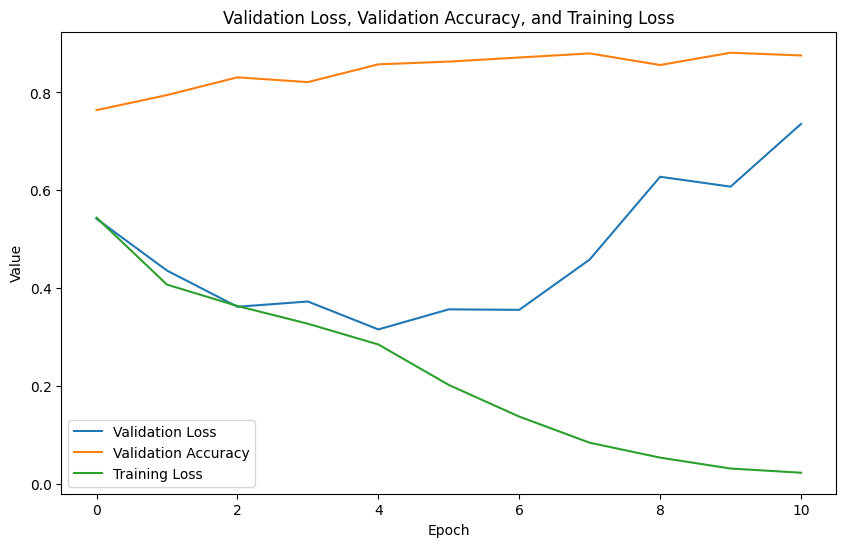

In [ ]:
#plotting validation loss, validation accuracy, and training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(validation_losses, label='Validation Loss')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Loss, Validation Accuracy, and Training Loss')
plt.legend()
plt.show()

Before implementing early stopping, we saw that there was some overfitting happening in the training loop, giving test accuracy of around 80%. This still occurs as seen in the above, where the validation loss increases after a few epochs. With this, we ended up with a higher testing accuracy close to 88%.

Test Accuracy with model.pth: 88.1988%
              precision    recall  f1-score   support

         0.0     0.8552    0.9430    0.8969       526
         1.0     0.9223    0.8091    0.8620       440

    accuracy                         0.8820       966
   macro avg     0.8887    0.8760    0.8795       966
weighted avg     0.8857    0.8820    0.8810       966

[[496  30]
 [ 84 356]]


<Axes: >

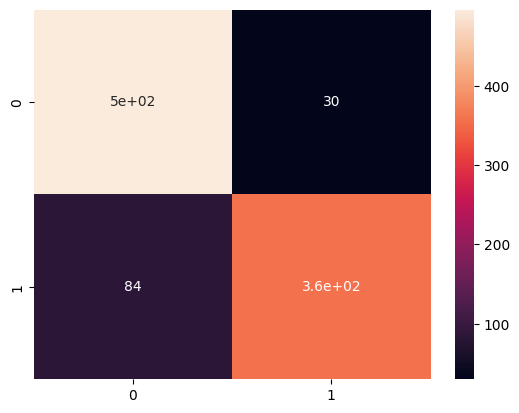

In [ ]:
#confusion matrix and error analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns

#testing the model
test_labels = torch.tensor(test_df['label'].values, dtype=torch.float32).unsqueeze(1)
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#load most optimal model (lowest validation loss) from training loop
lstm.load_state_dict(torch.load('model.pth'))
lstm.to(device)
lstm.eval()
preds = []
labels = []
with torch.no_grad():
  for batch_sequences, batch_labels in test_loader:
    batch_sequences = batch_sequences.to(device)

    logits = lstm(batch_sequences)
    probs = torch.sigmoid(logits)

    preds.extend((probs > 0.5).float().cpu().numpy())
    labels.extend(batch_labels.cpu().numpy())
test_accuracy = accuracy_score(labels, preds)
print(f"Test Accuracy with model.pth: {test_accuracy * 100:.4f}%")
print(classification_report(labels, preds, digits=4))
conf_matrix = confusion_matrix(labels, preds)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True)


Test Accuracy with model_acc.pth: 88.4058%
              precision    recall  f1-score   support

         0.0     0.9173    0.8650    0.8904       526
         1.0     0.8489    0.9068    0.8769       440

    accuracy                         0.8841       966
   macro avg     0.8831    0.8859    0.8837       966
weighted avg     0.8862    0.8841    0.8843       966



<Axes: >

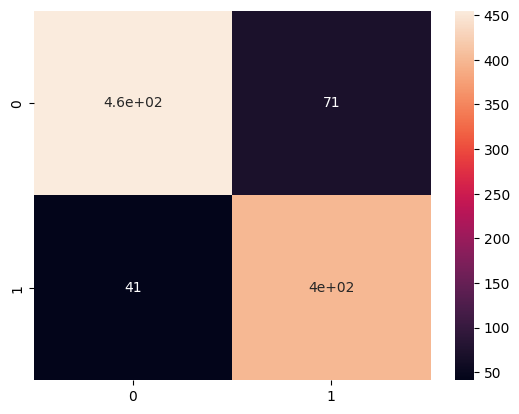

In [ ]:
#load most optimal model (best validation accuracy) from training loop
lstm.load_state_dict(torch.load('model_acc.pth'))
lstm.to(device)
lstm.eval()
preds = []
labels = []
with torch.no_grad():
  for batch_sequences, batch_labels in test_loader:
    batch_sequences = batch_sequences.to(device)

    logits = lstm(batch_sequences)
    probs = torch.sigmoid(logits)

    preds.extend((probs > 0.5).float().cpu().numpy())
    labels.extend(batch_labels.cpu().numpy())
test_accuracy = accuracy_score(labels, preds)
print(f"Test Accuracy with model_acc.pth: {test_accuracy * 100:.4f}%")
print(classification_report(labels, preds, digits=4))
confusion_matrix_acc = confusion_matrix(labels, preds)
sns.heatmap(confusion_matrix_acc, annot=True)

In [1]:
#importing libraries
!pip install gensim
import numpy as np
import pandas as pd
import matplotlib as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

#using word2vec for word embeddings
import nltk
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from gensim.models import Word2Vec


nltk.download('punkt_tab')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0); np.random.seed(0); random.seed(0)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
#loading datasets
train_df = pd.read_csv('train.csv')
print('train set has been loaded!')
train_df.name = 'train'
valid_df = pd.read_csv('valid.csv')
print('valid set has been loaded!')
valid_df.name = 'valid'
test_df = pd.read_csv('test.csv')
print('test set has been loaded!')
test_df.name = 'test'

train_labels = torch.tensor(
    train_df['label'].values,
    dtype=torch.float32
)
valid_labels = torch.tensor(
    valid_df['label'].values,
    dtype=torch.float32
)
test_labels = torch.tensor(
    test_df['label'].values,
    dtype=torch.float32
)


train set has been loaded!
valid set has been loaded!
test set has been loaded!


In [3]:
#looking at features of train_df, valid_df, and test_df:
def features(df):
  print(f"Dataset: {df.name}")
  print(f"Size: {df.shape}")
  print(f"Columns: {df.columns}")
  print(f"Null Values: {df.isnull().sum()}")
  print(f"Head: {df.head()}\n")
  print(f"Description:\n{df.describe()}\n")

  #longest phrase in dataset
  max_len = 0
  max_len_phrase = ""
  for i in range(len(df)):
    if len(df['text'][i]) > max_len:
      max_len = len(df['text'][i])
      max_len_phrase = df['text'][i]
  print(f"Longest Phrase in Dataset: \n{max_len_phrase}, \nchar length {max_len}")

  #count of sarcasm vs non-sarcasm
  sarcasm_count = df['label'].value_counts()[1]
  non_sarcasm_count = df['label'].value_counts()[0]
  print(f"Sarcasm Count: {sarcasm_count}")
  print(f"Non-Sarcasm Count: {non_sarcasm_count}")
  print("-----------------------------")

features(train_df)
features(valid_df)
features(test_df)

Dataset: train
Size: (21464, 2)
Columns: Index(['text', 'label'], dtype='object')
Null Values: text     0
label    0
dtype: int64
Head:                                                 text  label
0  states slow to shut down weak teacher educatio...      0
1    drone places fresh kill on steps of white house      1
2  report: majority of instances of people gettin...      1
3  sole remaining lung filled with rich, satisfyi...      1
4                       the gop's stockholm syndrome      0

Description:
              label
count  21464.000000
mean       0.475960
std        0.499433
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Longest Phrase in Dataset: 
hot wheels ranked number one toy for rolling down ramp, knocking over dominoes that send marble down a funnel, dropping onto teeter-totter that yanks on string, causing pulley system to raise wooden block, propelling series of twine rollers that unwind spring, launching tennis bal

Based on the information above, there does not seem to be any null values in any of the datasets.

In [4]:
#extract text from sarcasm labels
train_text = train_df['text']
valid_text = valid_df['text']
test_text = test_df['text']

#tokenizing them
def tokenize(series):
    data = []
    for text in series:
        tokens = [w.lower() for w in word_tokenize(text)]
        data.append(tokens)
    return data


train_tokens = tokenize(train_text)
print(train_tokens)
valid_tokens = tokenize(valid_text)
test_tokens = tokenize(test_text)

[['states', 'slow', 'to', 'shut', 'down', 'weak', 'teacher', 'education', 'programs'], ['drone', 'places', 'fresh', 'kill', 'on', 'steps', 'of', 'white', 'house'], ['report', ':', 'majority', 'of', 'instances', 'of', 'people', 'getting', 'lives', 'back', 'on', 'track', 'occur', 'immediately', 'after', 'visit', 'to', 'buffalo', 'wild', 'wings'], ['sole', 'remaining', 'lung', 'filled', 'with', 'rich', ',', 'satisfying', 'flavor'], ['the', 'gop', "'s", 'stockholm', 'syndrome'], ['trump', "'s", 'game', 'plan'], ['lea', 'michele', 'romances', 'fake', 'gosling', 'in', "'on", 'my', 'way', "'", 'video'], ['report', ':', 'that', 'whole', 'side', 'of', 'family', 'just', 'like', 'that'], ['new', 'extended', 'paternity', 'leave', 'offers', 'dads', 'more', 'time', 'to', 'lose', 'colleagues', "'", 'respect'], ['nation', 'hopeful', 'there', 'will', 'be', 'equally', 'random', 'chance', 'of', 'justice', 'for', 'future', 'victims', 'of', 'police', 'abuse'], ['sean', 'spicer', 'finally', 'calls', 'it', '

In [5]:
#using word2vec for pre-training
train_w2v = Word2Vec(
    sentences=train_tokens,
    min_count=1,
    sg=1
)

#getting vocab:
def build_vocab(tokens):
  counter = Counter(word for sent in tokens for word in sent)
  vocab = {
    "<PAD>": 0,
    "<UNK>": 1
  }
  for word in counter:
    vocab[word] = len(vocab)

  return vocab

train_vocab = build_vocab(train_tokens)


In [7]:
#building w2v -> embeddings (tensor) to be used by our model:
def get_embeddings(w2v, vocab):
  embedding_dim = 100
  vocab_size = len(vocab)

  embedding_matrix = np.random.normal(
      scale=0.6,
      size=(vocab_size, embedding_dim)
  )

  embedding_matrix[vocab["<PAD>"]] = np.zeros(embedding_dim)

  for word, idx in vocab.items():
      if word in w2v.wv:
          embedding_matrix[idx] = w2v.wv[word]
  #convert to tensor
  embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
  return embedding_matrix

train_embeddings = get_embeddings(train_w2v, train_vocab)

In [6]:
#converts tokens into numerical indices for model to interpret from
#also does padding/truncating
def numericalize(tokens, vocab, max_len=30):
  seq = [vocab.get(w, vocab["<UNK>"]) for w in tokens]
  return seq[:max_len] + [vocab["<PAD>"]] * max(0, max_len - len(seq))

train_sequences = torch.tensor([numericalize(s, train_vocab) for s in train_tokens])
valid_sequences = torch.tensor([numericalize(s, train_vocab) for s in valid_tokens])
test_sequences  = torch.tensor([numericalize(s, train_vocab) for s in test_tokens])

#print(train_sequences.max())
#print(len(train_vocab))
#print(train_embeddings.shape)


In [7]:
#uncomment only if you dont have GloVe already downloaded
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip -q glove.6B.zip

def load_glove_embeddings(glove_path, vocab, embed_dim=50):
    embeddings = {}
    with open(glove_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype="float32")
            embeddings[word] = vector

    embedding_matrix = np.zeros((len(vocab), embed_dim))

    for word, idx in vocab.items():
        if word in embeddings:
            embedding_matrix[idx] = embeddings[word]
        else:
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embed_dim,))

    return torch.tensor(embedding_matrix, dtype=torch.float32)
glove_embeddings = load_glove_embeddings(
    "glove.6B.50d.txt",
    train_vocab,
    embed_dim=50
)


In [8]:
class LSTMModel(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
    #loading w2v weights
    self.embed.weight.data.copy_(embed_matrix)
    self.embed.weight.requires_grad = True
    #using Bidirectional since that is good for retaining context
    self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.2)
    self.fc1 = nn.Linear(hidden_dim * 4, 1)

  def forward(self, x):
    emb = self.embed(x)
    out, (h_n, _) = self.lstm(emb)
    avg_pool = out.mean(dim=1)
    max_pool, _ = out.max(dim=1)
    h = torch.cat([avg_pool, max_pool], dim=1)
    logits = self.fc1(h)
    return logits.squeeze(1)

In [9]:
class LSTMModelGloVE(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.embed.weight.data.copy_(embed_matrix)
        #freeze embedding weights (not needed for training and makes it more stable)
        self.embed.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.2)
        self.drop1 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 4, 1) #concatenate both of the poolings, which are both hidden_dim * 2
        #self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
      emb = self.embed(x)
      out, (h_n, _) = self.lstm(emb)
      avg_pool = out.mean(dim=1)
      max_pool, _ = out.max(dim=1)
      #h = torch.cat([max_pool, avg_pool], dim=1)
      h = torch.cat([avg_pool, max_pool], dim=1)
      #h = self.drop1(avg_pool)
      #h = self.drop1(max_pool)
      h = self.drop1(h)
      return self.fc(h).squeeze(1)


In [10]:
#training model (and validating)
train_dataset = TensorDataset(train_sequences, train_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataset = TensorDataset(valid_sequences, valid_labels)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

lstm = LSTMModelGloVE(
    vocab_size=len(train_vocab),
    embed_dim=50,
    hidden_dim=128,
    embed_matrix=glove_embeddings
)
lstm.to(device)
loss_fn = nn.BCEWithLogitsLoss()
opt = torch.optim.Adam(lstm.parameters(), lr=0.001)

#keeping track of validation loss, traning loss, and validation accuracy for visual representation
validation_losses = []
training_losses = []
validation_accuracies = []
#early stopping parameters
best_loss = float('inf')
best_validation_acc = float('-inf')
epochs_not_improving = 0

#loop
for epoch in range(30):
  #training

  if epoch == 4:
    lstm.embed.weight.requires_grad = True
  lstm.train()

  total_loss = 0.0
  for batch_sequences, batch_labels in train_loader:
    batch_sequences = batch_sequences.to(device)
    batch_labels = batch_labels.to(device)

    opt.zero_grad()
    output = lstm(batch_sequences)
    loss = loss_fn(output, batch_labels)
    loss.backward()
    nn.utils.clip_grad_norm_(lstm.parameters(), 1.0) #gradient clipping to avoid exploding gradients
    opt.step()

    total_loss += loss.item()
  train_loss = total_loss / len(train_loader)

  #validating
  lstm.eval()
  validation_loss = 0.0
  preds = []
  labels = []
  with torch.no_grad():
    for batch_sequences, batch_labels in valid_loader:
      batch_sequences = batch_sequences.to(device)
      batch_labels = batch_labels.to(device)
      output = lstm(batch_sequences)
      loss = loss_fn(output, batch_labels)
      validation_loss += loss.item()
      preds.extend((torch.sigmoid(output) > 0.5).float().cpu().numpy())
      labels.extend(batch_labels.cpu().numpy())
  validation_loss /= len(valid_loader)
  validation_accuracy = accuracy_score(labels, preds)

  print(f"Epoch {epoch+1}/30 : Loss {train_loss} | Validation Loss: {validation_loss} | Validation Accuracy {validation_accuracy * 100:.4f}%")
  #either do early stopping or update to more optimal model
  if validation_accuracy > best_validation_acc:
    best_validation_acc = validation_accuracy
    torch.save(lstm.state_dict(), 'model_acc.pth')
    print("Model_acc saved!")
  if validation_loss < best_loss:
    best_loss = validation_loss
    torch.save(lstm.state_dict(), 'model.pth')
    print("Model saved!")
    epochs_not_improving = 0 #reset everytime model improves
  else:
    epochs_not_improving += 1
    if epochs_not_improving >= 7:
      print("Early stopping!")
      break

  #add information to data
  training_losses.append(train_loss)
  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_accuracy)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1/30 : Loss 0.5418259034021979 | Validation Loss: 0.45428627853592235 | Validation Accuracy 78.3520%
Model_acc saved!
Model saved!
Epoch 2/30 : Loss 0.4096490896439978 | Validation Loss: 0.399043008685112 | Validation Accuracy 83.1006%
Model_acc saved!
Model saved!
Epoch 3/30 : Loss 0.3508402883917803 | Validation Loss: 0.37572283297777176 | Validation Accuracy 82.8212%
Model saved!
Epoch 4/30 : Loss 0.31333302178730565 | Validation Loss: 0.3791961098710696 | Validation Accuracy 83.9385%
Model_acc saved!
Epoch 5/30 : Loss 0.2706010093069857 | Validation Loss: 0.32419121886293095 | Validation Accuracy 86.8715%
Model_acc saved!
Model saved!
Epoch 6/30 : Loss 0.19001492080722182 | Validation Loss: 0.3199469596147537 | Validation Accuracy 86.3128%
Model saved!
Epoch 7/30 : Loss 0.12390491312059264 | Validation Loss: 0.33980632945895195 | Validation Accuracy 87.2905%
Model_acc saved!
Epoch 8/30 : Loss 0.07461369948993836 | Validation Loss: 0.4342273299892743 | Validation Accuracy 86.4

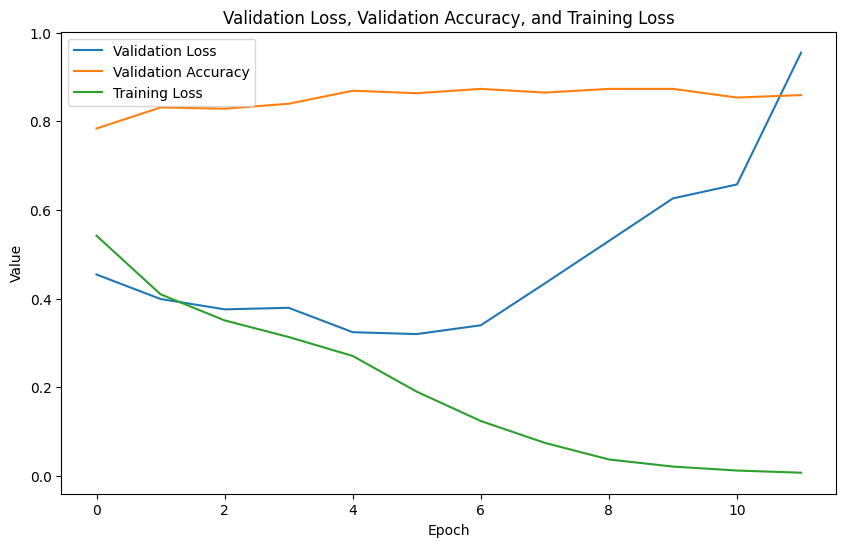

In [11]:
#plotting validation loss, validation accuracy, and training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(validation_losses, label='Validation Loss')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Validation Loss, Validation Accuracy, and Training Loss')
plt.legend()
plt.show()

Before implementing early stopping, we saw that there was some overfitting happening in the training loop, giving test accuracy of around 80%. This still occurs as seen in the above, where the validation loss increases after a few epochs. With this, we ended up with a higher testing accuracy close to 88%.

In [12]:
#testing the model
test_labels = torch.tensor(test_df['label'].values, dtype=torch.float32).unsqueeze(1)
test_dataset = TensorDataset(test_sequences, test_labels)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#load most optimal model from training loop
lstm.load_state_dict(torch.load('model.pth'))
lstm.to(device)
lstm.eval()
preds = []
labels = []
with torch.no_grad():
  for batch_sequences, batch_labels in test_loader:
    batch_sequences = batch_sequences.to(device)

    logits = lstm(batch_sequences)
    probs = torch.sigmoid(logits)

    preds.extend((probs > 0.5).float().cpu().numpy())
    labels.extend(batch_labels.cpu().numpy())
test_accuracy = accuracy_score(labels, preds)
print(f"Test Accuracy with model.pth: {test_accuracy * 100:.4f}%")


#load most optimal model from training loop
lstm.load_state_dict(torch.load('model_acc.pth'))
lstm.to(device)
lstm.eval()
preds = []
labels = []
with torch.no_grad():
  for batch_sequences, batch_labels in test_loader:
    batch_sequences = batch_sequences.to(device)

    logits = lstm(batch_sequences)
    probs = torch.sigmoid(logits)

    preds.extend((probs > 0.5).float().cpu().numpy())
    labels.extend(batch_labels.cpu().numpy())
test_accuracy = accuracy_score(labels, preds)
print(f"Test Accuracy with model_acc.pth: {test_accuracy * 100:.4f}%")

Test Accuracy with model.pth: 88.4058%
Test Accuracy with model_acc.pth: 87.7847%


In [13]:
#printing classification report
print(classification_report(labels, preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.8682    0.9144    0.8907       526
         1.0     0.8908    0.8341    0.8615       440

    accuracy                         0.8778       966
   macro avg     0.8795    0.8743    0.8761       966
weighted avg     0.8785    0.8778    0.8774       966



[[481  45]
 [ 73 367]]


<Axes: >

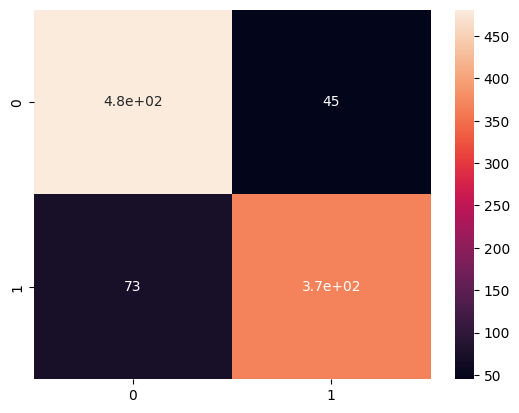

In [14]:
#confusion matrix and error analysis
from sklearn.metrics import confusion_matrix
import seaborn as sns

print(confusion_matrix(labels, preds))
sns.heatmap(confusion_matrix(labels, preds), annot=True)
